In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
import seaborn as sns
import pandas as pd
import math
from scipy.special import gammaln

In [53]:
encounters = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
frequencies = np.array([379, 299, 222, 145, 109, 95, 73, 59, 45, 30, 24, 12, 4, 2, 0, 1, 1])
N = frequencies.sum()
data = pd.DataFrame({
    'encounters': encounters,
    'frequencies': frequencies
})

<Axes: xlabel='encounters', ylabel='frequencies'>

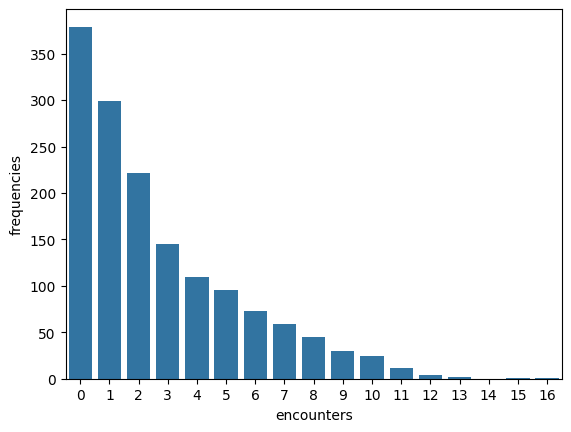

In [54]:
sns.barplot(x='encounters', y='frequencies', data=data)

In [55]:
# Initialize parameters
np.random.seed(42)
alpha = 0.3  # Probability of always reporting zero
beta = 0.4   # Probability of belonging to typical-risk group
mu = 3       # Mean of Poisson distribution for typical-risk group
lam = 8      # Mean of Poisson distribution for high-risk group

In [56]:
def poisson_pmf(x, mean):
    """ Compute Poisson probability mass function (PMF). """
    return (mean ** x) * np.exp(-mean) / math.factorial(x)

In [57]:
def e_step(encounters, frequencies, alpha, beta, mu, lam):
    """Expectation step: Compute responsibilities (posterior probabilities)."""
    responsibilities = np.zeros((len(encounters), 3))  # Columns: [Zero, Typical, High-Risk]

    for i in range(len(encounters)):
        x = encounters[i]

        # Compute probabilities for each group
        pi_zero = alpha if x == 0 else 0
        pi_typical = beta * poisson_pmf(x, mu)
        pi_high = (1 - alpha - beta) * poisson_pmf(x, lam)

        # Total probability for normalization
        total_prob = pi_zero + pi_typical + pi_high

        # Compute responsibilities
        responsibilities[i, 0] = pi_zero / total_prob if total_prob > 0 else 0  # Group Z
        responsibilities[i, 1] = pi_typical / total_prob if total_prob > 0 else 0  # Group T
        responsibilities[i, 2] = pi_high / total_prob if total_prob > 0 else 0  # Group P

    # Multiply by frequencies
    responsibilities *= frequencies[:, None]

    return responsibilities

In [58]:
def m_step(responsibilities, encounters):
    """Maximization step: Update parameters α, β, μ, λ."""
    Nk = np.sum(responsibilities, axis=0)  # Sum of responsibilities for each group
    N_total = np.sum(Nk)

    # Update parameters
    alpha_new = Nk[0] / N_total
    beta_new = Nk[1] / N_total
    mu_new = np.sum(responsibilities[:, 1] * encounters) / Nk[1]
    lam_new = np.sum(responsibilities[:, 2] * encounters) / Nk[2]

    return alpha_new, beta_new, mu_new, lam_new

In [ ]:
def log_likelihood(encounters,frequencies,alpha, beta, mu, lambd):
    logL = 0
    for i, n_i in zip(encounters,frequencies):
        pi_i = alpha * (i == 0) + beta * poisson.pmf(i, mu) + (1 - alpha - beta) * poisson.pmf(i, lambd)
        logL += n_i * np.log(pi_i)
    return logL

In [61]:
def q_function(encounters, frequencies, responsibilities, alpha, beta, mu, lam):
    """
    Compute the Q function for the Poisson Mixture Model.

    Args:
        encounters (np.array): Array of number of encounters (0 to 16).
        frequencies (np.array): Array of frequencies of encounters.
        responsibilities (np.array): Matrix of responsibilities for each group (shape: [num_data_points, num_groups]).
        alpha (float): Current probability of the zero encounters group.
        beta (float): Current probability of the typical-risk group.
        mu (float): Current parameter for the Poisson distribution of the typical-risk group.
        lam (float): Current parameter for the Poisson distribution of the high-risk group.

    Returns:
        float: The value of the Q function.
    """
    q_value = 0
    for i in range(len(encounters)):  # For each encounter
        for k in range(3):  # For each group
            if k == 0:  # Zero encounters group
                pi_k = alpha
                poisson_val = poisson.pmf(encounters[i], 0)  # Poisson(0)
            elif k == 1:  # Typical group (Poisson with mu)
                pi_k = beta
                poisson_val = poisson.pmf(encounters[i], mu)
            else:  # High-risk group (Poisson with lambda)
                pi_k = 1 - alpha - beta
                poisson_val = poisson.pmf(encounters[i], lam)
                
            # Add the weighted log-likelihood to the Q function
            q_value += responsibilities[i, k] * np.log(pi_k * poisson_val + 1e-10)  # Add a small constant for numerical stability

    return q_value

In [ ]:
def em_algorithm(encounters, frequencies, alpha, beta, mu, lam, max_iterations=1000, tolerance=1e-6):
    """
    Implements the Expectation-Maximization (EM) algorithm for the Poisson Mixture Model.

    Args:
        encounters (np.array): Array of number of encounters (0 to 16).
        frequencies (np.array): Array of frequencies of encounters.
        alpha (float): Initial probability of the group with zero encounters.
        beta (float): Initial probability of the typical-risk group.
        mu (float): Initial parameter for the Poisson distribution of the typical-risk group.
        lam (float): Initial parameter for the Poisson distribution of the high-risk group.
        max_iterations (int): Maximum number of iterations to run the EM algorithm.
        tolerance (float): Convergence tolerance for the log-likelihood.

    Returns:
        (alpha, beta, mu, lam): Estimated parameters after convergence.
    """
    prev_likelihood = 0
    LK = []

    for iteration in range(max_iterations):
        # E-step: Calculate responsibilities (posterior probabilities for each group)
        responsibilities = e_step(encounters, frequencies, alpha, beta, mu, lam)

        # M-step: Update the parameters (alpha, beta, mu, lam)
        alpha_new, beta_new, mu_new, lam_new = m_step(responsibilities, encounters)

        # Compute the log-likelihood using the current responsibilities and parameters
        likelihood = log_likelihood(encounters,frequencies, alpha_new, beta_new, mu_new, lam_new)
        

        # Check for convergence based on the change in the log-likelihood
        if np.abs(likelihood - prev_likelihood) < tolerance:
            print(f"Converged at iteration {iteration + 1}")
            break

        # Update parameters for the next iteration
        alpha, beta, mu, lam = alpha_new, beta_new, mu_new, lam_new
        prev_likelihood = likelihood
        #store the log-likelihood values
        LK.append(likelihood)
    
    return alpha, beta, mu, lam, LK  # Return the estimated parameters and the log-likelihood values

In [63]:
alpha, beta, mu, lam, LK = em_algorithm(encounters, frequencies, alpha, beta, mu, lam)

Converged at iteration 82


Text(0.5, 1.0, 'Log-Likelihood convergence')

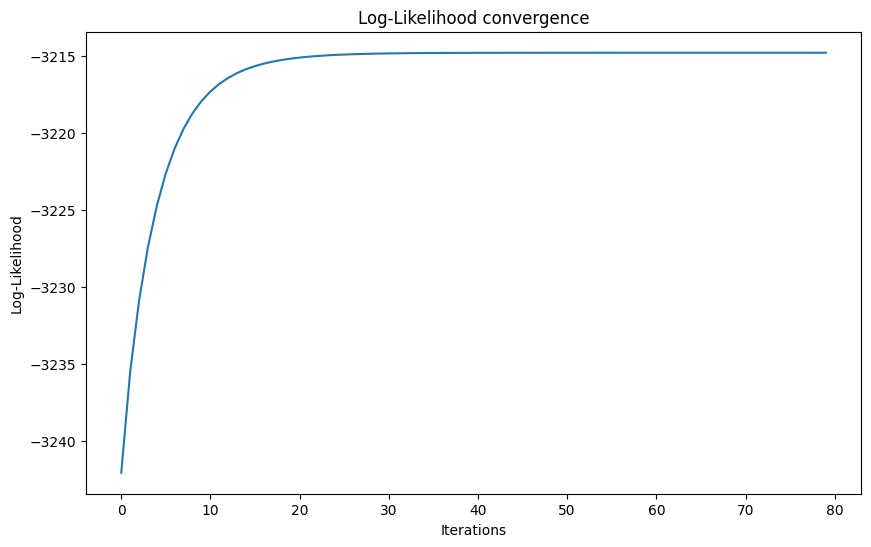

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(LK[2:])
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood convergence')

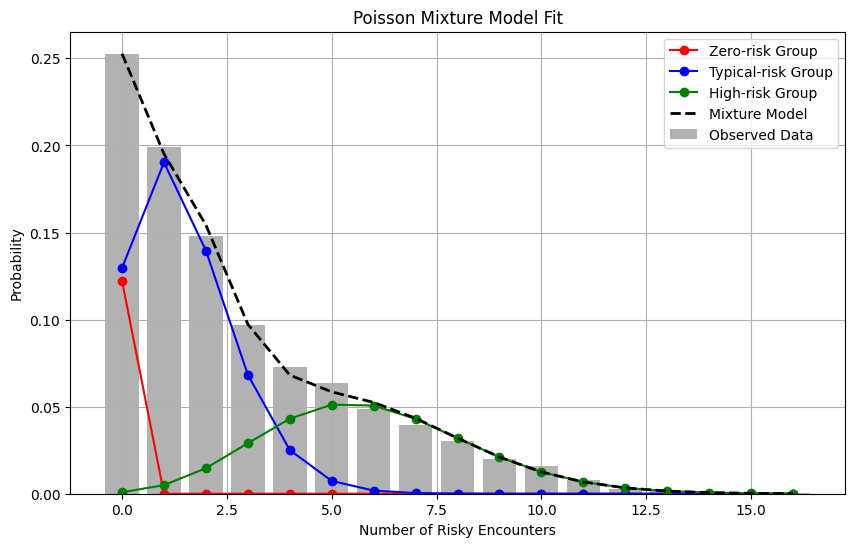

In [65]:
def plot_poisson_mixture(encounters, frequencies, alpha, beta, mu, lam):
    x = np.arange(0, max(encounters) + 1)
    
    # Compute Poisson PMFs
    poisson_zero = (x == 0).astype(float)  # Only nonzero at x = 0
    poisson_typical = poisson.pmf(x, mu)
    poisson_high_risk = poisson.pmf(x, lam)

    # Weighted contributions
    weighted_zero = alpha * poisson_zero
    weighted_typical = beta * poisson_typical
    weighted_high_risk = (1 - alpha - beta) * poisson_high_risk

    # Mixture distribution
    mixture_pmf = weighted_zero + weighted_typical + weighted_high_risk

    # Normalize frequencies for visualization
    normalized_frequencies = frequencies / np.sum(frequencies)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(encounters, normalized_frequencies, color='gray', alpha=0.6, label="Observed Data")
    plt.plot(x, weighted_zero, 'ro-', label="Zero-risk Group")
    plt.plot(x, weighted_typical, 'bo-', label="Typical-risk Group")
    plt.plot(x, weighted_high_risk, 'go-', label="High-risk Group")
    plt.plot(x, mixture_pmf, 'k--', label="Mixture Model", linewidth=2)

    plt.xlabel("Number of Risky Encounters")
    plt.ylabel("Probability")
    plt.title("Poisson Mixture Model Fit")
    plt.legend()
    plt.grid()
    plt.show()


plot_poisson_mixture(encounters, frequencies, alpha, beta, mu, lam)

In [66]:
def random_initialization():
    """Generates random initial values ensuring valid constraints."""
    alpha = np.random.uniform(0, 1)
    beta = np.random.uniform(0, 1 - alpha)  # Ensure alpha + beta ≤ 1
    mu = np.random.uniform(0.1, 10)  # Ensure mu is positive
    lam = np.random.uniform(mu + 1, 20)  # Ensure λ > μ
    return alpha, beta, mu, lam


In [67]:
# Number of random initializations
num_trials = 10
final_log_likelihoods = []

for trial in range(num_trials):
    # Generate random starting values
    alpha_init, beta_init, mu_init, lam_init = random_initialization()
    
    # Run EM algorithm
    alpha_est, beta_est, mu_est, lam_est, LK = em_algorithm(
        encounters, frequencies, alpha_init, beta_init, mu_init, lam_init
    )
    
    # Store the final log-likelihood
    final_log_likelihoods.append(LK[-1])  # Last log-likelihood value

# Print results
print("Final log-likelihoods from different initializations:")
for i, ll in enumerate(final_log_likelihoods):
    print(f"Run {i+1}: {ll:.5f}")

# Check if the likelihood values vary significantly
if np.std(final_log_likelihoods) > 1e-3:
    print("\n🔴 Evidence of multimodality: Different likelihood values were obtained.")
else:
    print("\n🟢 No strong evidence of multimodality: All runs converged to similar values.")

Converged at iteration 91
Converged at iteration 78
Converged at iteration 79
Converged at iteration 60
Converged at iteration 85
Converged at iteration 77
Converged at iteration 84
Converged at iteration 77
Converged at iteration 92
Converged at iteration 83
Final log-likelihoods from different initializations:
Run 1: -3214.78135
Run 2: -3214.78135
Run 3: -3214.78135
Run 4: -3214.78135
Run 5: -3214.78135
Run 6: -3214.78135
Run 7: -3214.78135
Run 8: -3214.78135
Run 9: -3214.78135
Run 10: -3214.78135

🟢 No strong evidence of multimodality: All runs converged to similar values.
